# Predict Bike Sharing Demand with AutoGluon


In this project, I'll use the AutoGluon library to train several models for the Bike Sharing Demand competition in Kaggle. I will be using Tabular Prediction to fit data from CSV files provided by the competition. This project will demonstrate my ability to use AutoGluon to train several iterations of models and record my personal optimization of the problem.

Bike-sharing demand is highly relevant to related problems companies encounter, such as Uber, Lyft, and DoorDash. Predicting demand not only helps businesses prepare for spikes in their services but also improves customer experience by limiting delays.

## Step 1: Install necessary packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle


  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-63.4.1-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 145.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "osamakhedr"
kaggle_key = "6df65178ceea7990472ab76d8d13288c"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
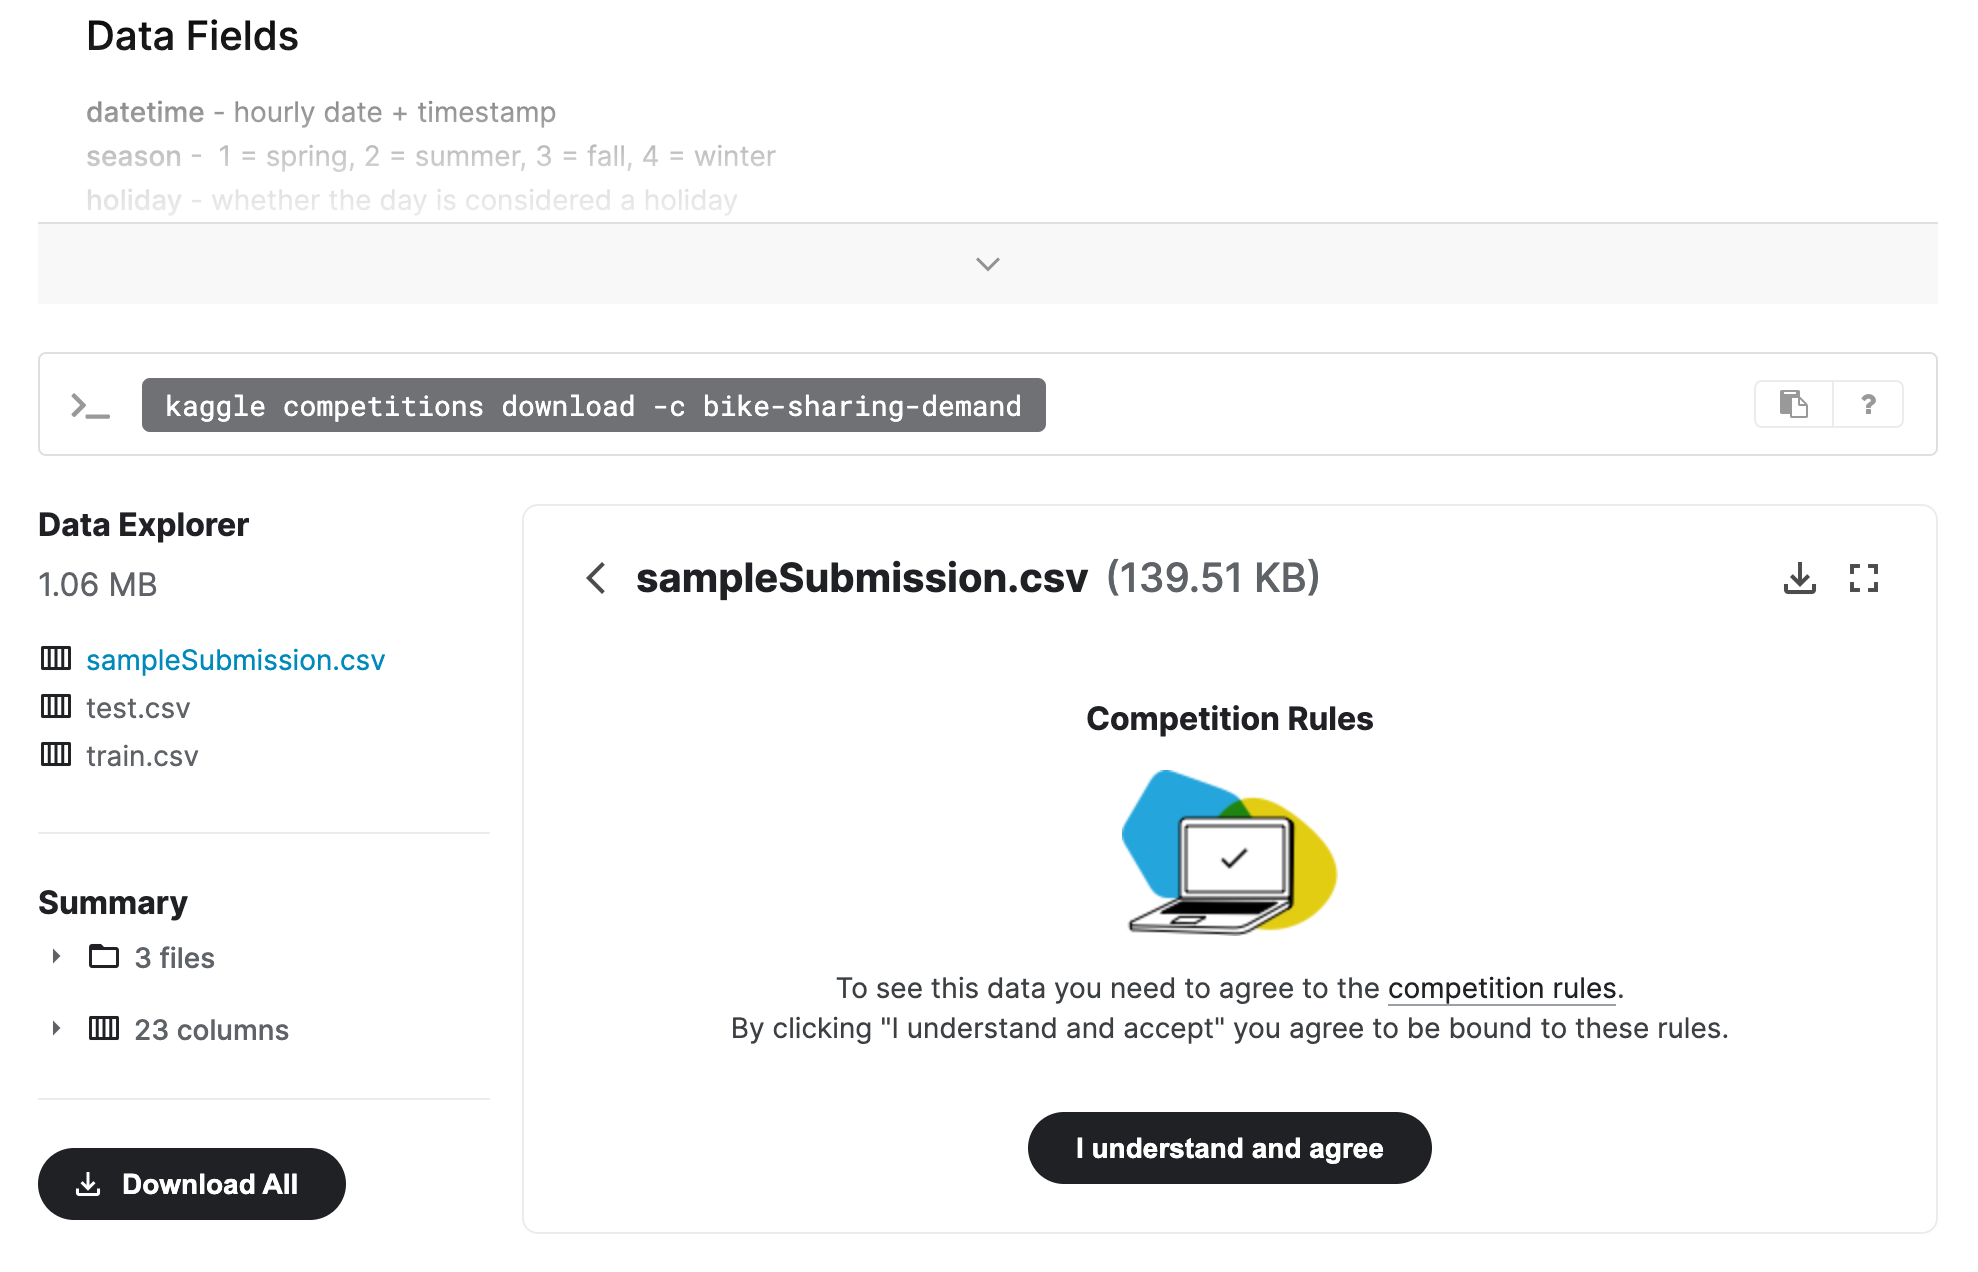

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 7.40MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [13]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6493 non-null   datetime64[ns]
 1   count     6493 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 101.6 KB


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [14]:
predictor = TabularPredictor(label="count",eval_metric="root_mean_squared_error",problem_type="regression",learner_kwargs={"ignored_columns": ["casual", "registered"]}).\
fit(train_data=train,time_limit=600,presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220806_184906/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220806_184906/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3041.75 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 fe

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.774813      11.111861  511.648680                0.000741           0.365116            3       True         15
1   RandomForestMSE_BAG_L2  -53.323251      10.158032  411.765777                0.583942          25.787401            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.811435      10.151867  393.933742                0.577777           7.955366            2       True         14
3          LightGBM_BAG_L2  -55.115736       9.861812  408.158431                0.287723          22.180055            2       True         11
4          CatBoost_BAG_L2  -55.648026       9.661678  455.360741                0.087589          69.382366            2       True         13
5        LightGBMXT_BAG_L2  -60.496389      12.613077  436.013067         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [16]:
predictions = predictor.predict(test)
predictions.head()

0    23.621372
1    41.231117
2    44.782562
3    47.737030
4    50.857910
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.805695
std        90.365700
min         2.794254
25%        20.528816
50%        62.849258
75%       170.513962
max       364.590302
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
predictions[predictions<0].count()

0

In [19]:
# Set them to zero
predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [20]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 485kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-08-06 18:59:39  first raw submission               complete  1.80815      1.80815       
submission_new_hpo.csv       2022-08-06 16:14:17  new features with hyperparameters  complete  0.50729      0.50729       
submission_new_features.csv  2022-08-06 15:59:39  new features                       complete  0.69028      0.69028       
submission.csv               2022-08-06 15:48:46  first raw submission               complete  1.80630      1.80630       


#### Initial score of `1.80815`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

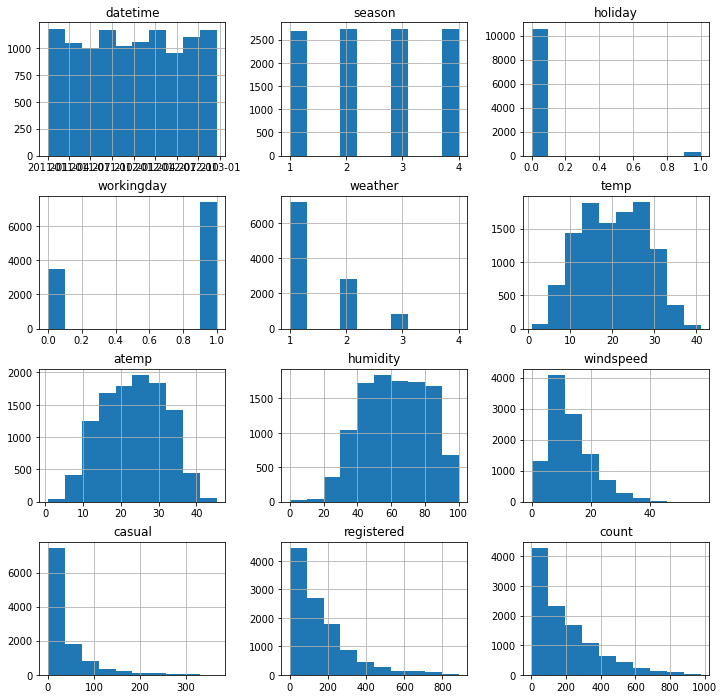

In [23]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(12,12));

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [25]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

In [26]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [27]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [28]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


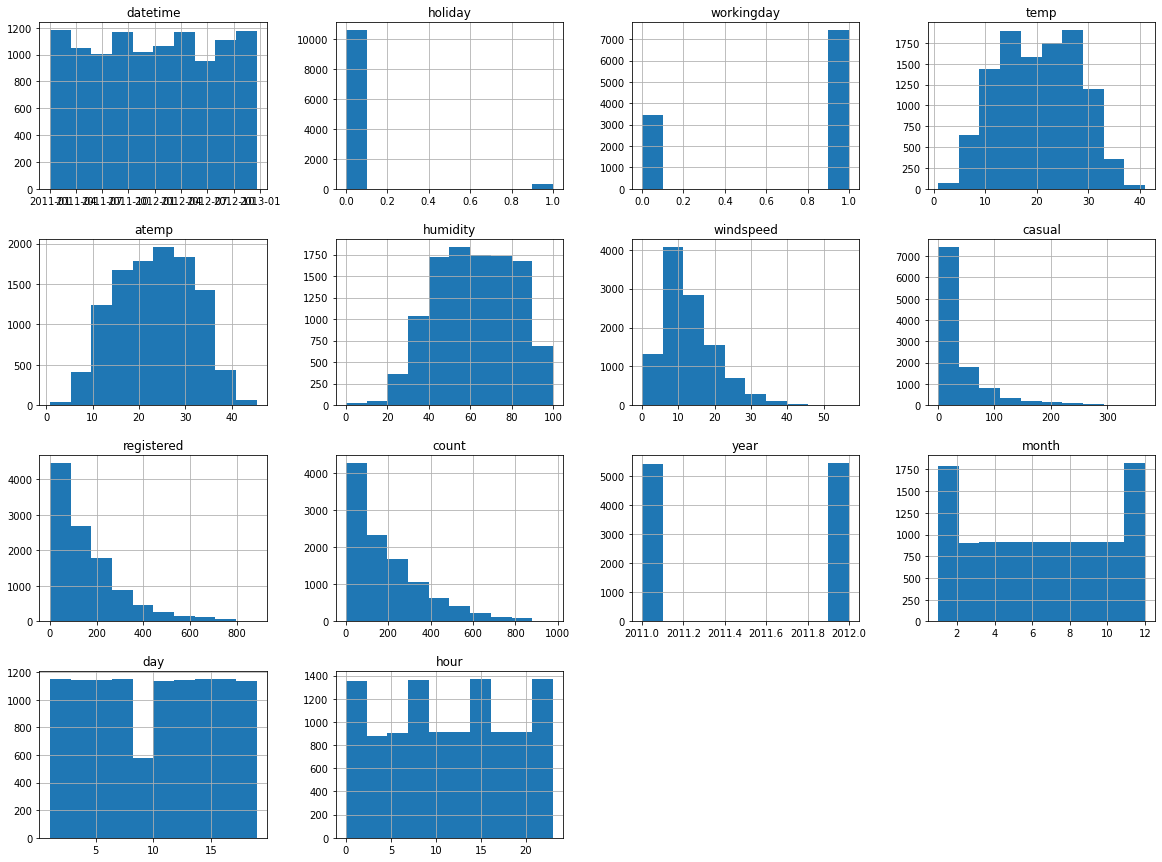

In [29]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(20,15));

## Step 5: Rerun the model with the same settings as before, just with more features

In [30]:
predictor_new_features = TabularPredictor(label="count",eval_metric="root_mean_squared_error",problem_type="regression",learner_kwargs={"ignored_columns": ["casual", "registered"]}).\
fit(train_data=train,time_limit=600,presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220806_185945/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220806_185945/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2139.45 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 fe

In [31]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.109275      16.360132  559.031713                0.001066           0.571565            3       True         15
1          LightGBM_BAG_L2  -30.431725      14.680642  419.833951                0.343303          22.672645            2       True         11
2          CatBoost_BAG_L2  -30.438711      14.462320  478.358238                0.124980          81.196932            2       True         13
3        LightGBMXT_BAG_L2  -31.299177      15.282893  424.054435                0.945554          26.893129            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.523949      14.941640  406.423544                0.604301           9.262238            2       True         14
5   RandomForestMSE_BAG_L2  -31.554278      14.945229  427.697442         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.34599701170154,
  'LightGBM_BAG_L1': -3

In [32]:
# How many negative values do we have?
improved_predictions=predictor_new_features.predict(test)
improved_predictions[improved_predictions<0].count()

0

In [33]:
# Set them to zero
improved_predictions[improved_predictions<0] = 0

In [34]:
# Same submitting predictions
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = improved_predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [35]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 516kB/s]
Successfully submitted to Bike Sharing Demand

In [36]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-08-06 19:10:31  new features                       complete  0.68488      0.68488       
submission.csv               2022-08-06 18:59:39  first raw submission               complete  1.80815      1.80815       
submission_new_hpo.csv       2022-08-06 16:14:17  new features with hyperparameters  complete  0.50729      0.50729       
submission_new_features.csv  2022-08-06 15:59:39  new features                       complete  0.69028      0.69028       


#### New Score of `0.68488`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [37]:
import autogluon.core as ag

In [38]:
# https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit
# https://auto.gluon.ai/scoredebugweight/api/autogluon.core.space.html
predictor_new_hpo = TabularPredictor(label='count', eval_metric='root_mean_squared_error',problem_type='regression',learner_kwargs={'ignored_columns':
['casual', 'registered']}).\
fit(train_data=train, time_limit=15*60, presets='best_quality',\
hyperparameters={'GBM':{'num_boost_round': 80, 'num_leaves': ag.space.Int(lower=18, upper=48, default=32)},'XGB':{'max_depth':5,'eta':0.2,'sampling_method':'gradient_based'}},\
hyperparameter_tune_kwargs={'num_trials':2,'searcher':'auto','scheduler' : 'local'})

No path specified. Models will be saved in: "AutogluonModels/ag-20220806_191034/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20220806_191034/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2209.21 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 fe

In [39]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   LightGBM_BAG_L2/T2 -36.017982       4.993109  591.925676                1.052824         133.220843            2       True          5
1  WeightedEnsemble_L3 -36.017982       4.994287  592.177260                0.001178           0.251584            3       True          6
2   LightGBM_BAG_L2/T1 -36.513596       4.919028  589.949872                0.978743         131.245040            2       True          4
3   LightGBM_BAG_L1/T2 -37.206288       2.097131  228.689980                2.097131         228.689980            1       True          2
4  WeightedEnsemble_L2 -37.206288       2.097885  228.867173                0.000754           0.177193            2       True          3
5   LightGBM_BAG_L1/T1 -42.934950       1.843154  230.014852                1.843154         230.014852 

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -42.93495022149506,
  'LightGBM_BAG_L1/T2': -37.206287978818196,
  'WeightedEnsemble_L2': -37.206287978818196,
  'LightGBM_BAG_L2/T1': -36.51359561921046,
  'LightGBM_BAG_L2/T2': -36.017981992721005,
  'WeightedEnsemble_L3': -36.017981992721005},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBM_BAG_L1/T1': 'AutogluonModels/ag-20220806_191034/models/LightGBM_BAG_L1/T1/',
  'LightGBM_BAG_L1/T2': 'AutogluonModels/ag-20220806_191034/models/LightGBM_BAG_L1/T2/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20220806_191034/models/WeightedEnsemble_L2/',
  'LightGBM_BAG_L2/T1': 'AutogluonModels/ag-20220806_191034/mo

In [40]:
# Remember to set all negative values to zero
hpo_predictions = predictor_new_hpo.predict(test)
hpo_predictions[hpo_predictions<0].count()

0

In [41]:
hpo_predictions[hpo_predictions<0]=0

In [42]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo["count"] = hpo_predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [43]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 452kB/s]
Successfully submitted to Bike Sharing Demand

In [44]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-08-06 19:25:16  new features with hyperparameters  complete  0.50729      0.50729       
submission_new_features.csv  2022-08-06 19:10:31  new features                       complete  0.68488      0.68488       
submission.csv               2022-08-06 18:59:39  first raw submission               complete  1.80815      1.80815       
submission_new_hpo.csv       2022-08-06 16:14:17  new features with hyperparameters  complete  0.50729      0.50729       


#### New Score of `0.50729`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

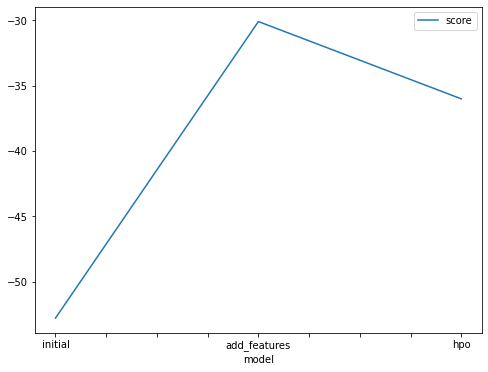

In [45]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
          predictor.leaderboard(silent=True)['score_val'][0],
          predictor_new_features.leaderboard(silent=True)['score_val'][0],
          predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
        ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

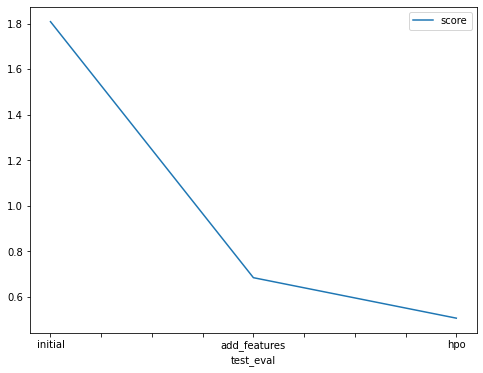

In [48]:
# Take the 3 kaggle scores and creating a line plot to show improvement
initial=1.80815
add_features=0.68488
hpo=0.50729
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [initial,add_features,hpo]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [52]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "time_limit": [600, 600, 900],
    "GBM":["num_boost_round: 80", "num_leaves:(lower=18, upper=48, default=32)",'default vals'],
    'XGB':['max_depth:5','eta:0.2','sampling_method:gradient_based'],
    "score": [initial,add_features,hpo]
})

,model,time_limit,GBM,XGB,score
0,initial,600,num_boost_round: 80,max_depth:5,1.80815
1,add_features,600,"num_leaves:(lower=18, upper=48, default=32)",eta:0.2,0.68488
2,hpo,900,default vals,sampling_method:gradient_based,0.50729
